# Benchmark com Microsoft GrabCut (50 imagens)

Utilizando a métrica _error rate_, esse notebook propõe-se construir uma avaliação no dataset grabcut para avaliar a taxa de erro médio para o algoritmo EGSIS. A intenção é realizar uma comparação com as técnicas avaliadas no artigo _Segmentation by t

O. Duchenne, J. -Y. Audibert, R. Keriven, J. Ponce and F. Segonne, "Segmentation by transduction," 2008 IEEE Conference on Computer Vision and Pattern Recognition, Anchorage, AK, USA, 2008, pp. 1-8, doi: 10.1109/CVPR.2008.4587419.

In [1]:
import os
os.environ["LOGURU_LEVEL"] = "ERROR"

In [2]:
from egsis.datasets import grabcut
import matplotlib.pyplot as plt
from egsis import model
from egsis import metrics

# Avaliação única aleatória

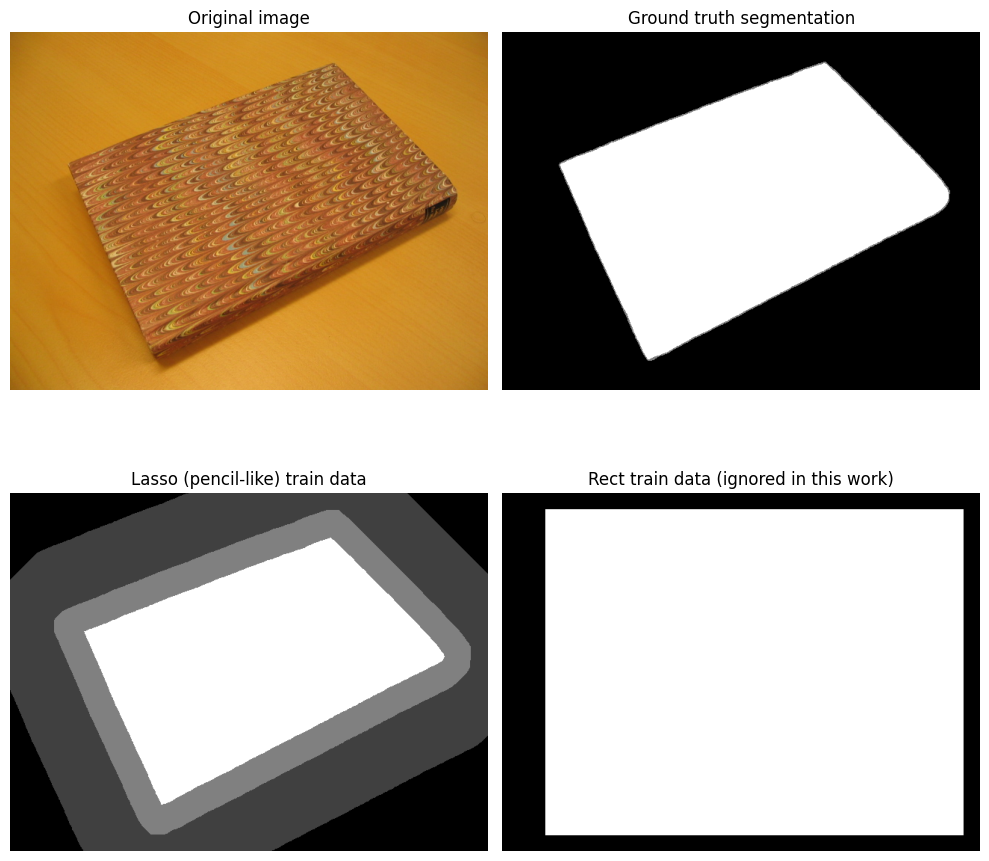

In [3]:
img = grabcut.get_random_image()
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(img.data)
ax[0, 0].set_title("Original image")
ax[0, 1].imshow(img.segmentation, cmap="gray")
ax[0, 1].set_title("Ground truth segmentation")
ax[1, 0].imshow(img.lasso, cmap="gray")
ax[1, 0].set_title("Lasso (pencil-like) train data")
ax[1, 1].imshow(img.rect, cmap="gray")
ax[1, 1].set_title("Rect train data (ignored in this work)")


for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()

# Labelling description 

**Segmentation**: A tri-map which specifies background (0), foreground (255) and
mixed area (128). The mixed area contains pixels which are a combination of foreand background texture. Note, in low contrast regions the true boundary is not
observed and the ground truth is in this case a "good guess".

**Labelling-Lasso**: Imitates a tri-map obtained by a lasso or pen tool. The colour
coding is: 

- background (0);
- background - used for colour model training (64);
- inference (unknown) region (128);
- foreground - used for colour model training (255).

Note, a lasso tool can be imitated by specifying the foreground region (255) as unknown
(128).

**Labelling-Rectangle**: Imitates a tri-map obtained by two mouse clicks (rectangle).
Same colour coding as in Labelling-Lasso.

In [4]:
# Preprocessing labeling scheme
# y_train = img.lasso
# y_train[y_train == 64] = 1 # background
# y_train[y_train == 128] = 0 # means unlabelled for egsis
# y_train[y_train == 255] = 2 # foreground
# y_true = img.segmentation
# y_true[y_true == 128] = 1
# y_true[y_true == 255] = 1

# not more necessary the steps above, replaced by:
y_train = img.y_train()
y_true = img.y_true()

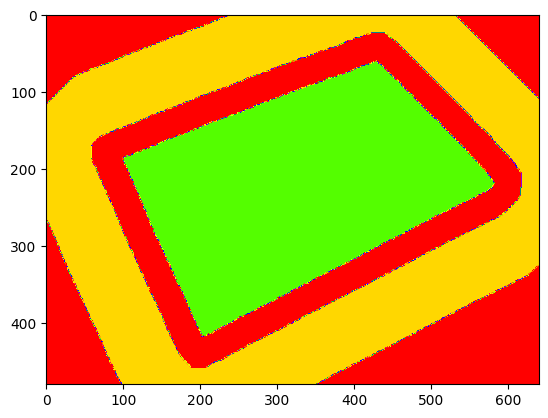

In [5]:
plt.imshow(y_train, cmap="prism")  

# the green region it's training data for background
# the yellow region it's training data for foreground

(-0.5, 639.5, 479.5, -0.5)

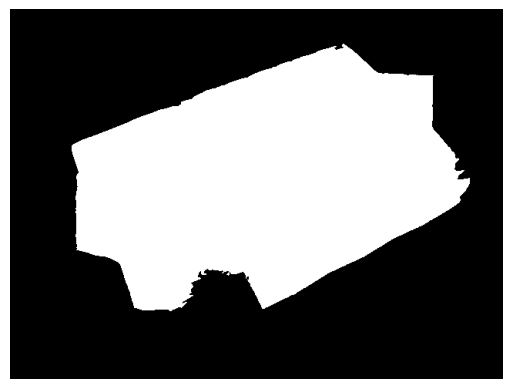

In [6]:
X = img.data
y = y_train

m = model.EGSIS(
    superpixel_segments=50,
    superpixel_sigma=0.8,
    superpixel_compactness=40,
    feature_extraction="comatrix",
    lcu_max_iter=100,
    feature_similarity="euclidian_exp",
)

# Fit predict receiving a image mask
# re-encoding y-values to be in {0,1} because for EGSIS, y=0 means non-labeled
mask = m.fit_predict_segmentation_mask(X, y) - 1
plt.imshow(mask, cmap="gray")
plt.axis('off')

In [7]:
y_train.shape

(480, 640)

In [8]:
X.shape

(480, 640, 3)

In [9]:
import numpy as np
np.unique(y_train)

array([0, 1, 2], dtype=uint8)

In [10]:
y_pred = mask
err = metrics.err(y_true, y_pred) * 100
iou = metrics.iou(y_true, y_pred)
f1 = metrics.f1(y_true, y_pred)
acc = metrics.pixel_accuracy(y_true, y_pred)
print("Segmentation Metrics!")
print(f"Err:\t{round(err, 2)}%") 
print(f"IoU:\t{round(iou, 2)}") 
print(f"F1:\t{round(f1, 2)}") 
print(f"acc:\t{round(acc, 2)}") 

Segmentation Metrics!
Err:	7.63%
IoU:	0.86
F1:	0.35
acc:	0.94


# Avaliação em Lote

In [11]:
%%time
import pandas as pd
imgs = grabcut.get_all_dataset()
stats = []
for img in imgs:
    X = img.data
    y_true = img.y_true()
    y_train = img.y_train()
    mask = m.fit_predict_segmentation_mask(X, y_train)
    # label re-encoding
    y_pred = mask - 1
    err = metrics.err(y_true, y_pred) * 100
    iou = metrics.iou(y_true, y_pred)
    f1 = metrics.f1(y_true, y_pred)
    acc = metrics.pixel_accuracy(y_true, y_pred)
    stat = [img.fname, err, iou, f1, acc]
    stats.append(stat)

df = pd.DataFrame(stats, columns=["name", "err", "iou", "f1", "acc"])
df

CPU times: user 3min 52s, sys: 746 ms, total: 3min 52s
Wall time: 3min 52s


,name,err,iou,f1,acc
0,memorial.jpg,4.835019,0.807944,0.160389,0.961874
1,person1.jpg,4.232073,0.946890,0.285726,0.983974
2,271008.jpg,0.410460,0.599715,0.084566,0.943556
3,sheep.jpg,12.585766,0.680289,0.042170,0.980181
4,person3.jpg,8.101545,0.782282,0.085130,0.976307
5,153093.jpg,12.850371,0.646882,0.091761,0.949910
6,banana2.bmp,1.916476,0.804011,0.201257,0.950941
7,doll.bmp,8.265921,0.914157,0.367082,0.965530
8,stone1.JPG,1.279711,0.859935,0.169258,0.972432
9,21077.jpg,4.807164,0.733082,0.090576,0.967021


In [12]:
df.describe()

,err,iou,f1,acc
count,50.000000,50.000000,50.000000,50.000000
mean,6.758233,0.741161,0.176785,0.951304
std,6.389149,0.155745,0.115399,0.026538
min,0.000000,0.322330,0.023181,0.875616
25%,1.882980,0.664782,0.085831,0.939545
50%,4.855121,0.767684,0.150584,0.954729
75%,8.521082,0.860144,0.218588,0.969657
max,30.773805,0.951190,0.501104,0.992122
